In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickles
plt.style.use('fivethirtyeight')
%matplotlib inline


In [2]:
all_data = pd.read_pickle("./pickles/all_data.pkl")

A concise format of how to approach the grouping. (I did manage to this without much guidance). But I do appreciate this workbook is able to consisely explain the process I followed.

Define Variable Categories

There are several different categories of variables:

Individual Variables: these are characteristics of each individual rather than the household
- Boolean: Yes or No (0 or 1)
- Ordered Discrete: Integers with an ordering

Household variables
- Boolean: Yes or No
- Ordered Discrete: Integers with an ordering

Continuous numeric
- Squared Variables: derived from squaring variables in the data
- Id variables: identifies the data and should not be used as features

Below we manually define the variables in each category. This is a little tedious, but also necessary.

In [3]:
# Correctly labeling the data
# Unfortunaly, since the data cannot be structured, I think it's worthwhile to look at the data

# Ids
id_ = ['Id', 'idhogar', 'Target']

# Looking at individuals variables (meaning individuals in the same household should have diff. values)
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 'parentesco1', 
            'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 
            'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 'parentesco11', 
            'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 
            'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

# Looking at households variables
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 'paredpreb',
           'pisocemento', 'pareddes', 'paredmad','paredzinc', 'paredfibras', 'paredother', 
           'pisomoscer', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera','techozinc', 
           'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 'abastaguadentro', 
           'abastaguafuera', 'abastaguano', 'public', 'planpri', 'noelec', 'coopele', 
           'sanitario1', 'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6', 'energcocinar1', 
           'energcocinar2', 'energcocinar3', 'energcocinar4', 'elimbasu1', 'elimbasu2', 'elimbasu3', 
           'elimbasu4', 'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3', 'etecho1', 
           'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'tipovivi1', 'tipovivi2', 'tipovivi3', 
           'tipovivi4', 'tipovivi5', 'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = ['rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

# Storing the squared variables
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 
        'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']


In [4]:
# Double checking there are no repated variables and they are in the list
from collections import Counter

columns_x = id_ + ind_bool + ind_ordered + hh_bool + hh_cont + hh_ordered + sqr_
print('There are no repeated values', np.all(np.array(list(Counter(columns_x).values())) == 1))
print('We covered every variable: ', len(columns_x) == all_data.shape[1])


There are no repeated values True
We covered every variable:  True


## Analyze: Columns Type

### Squared Columns

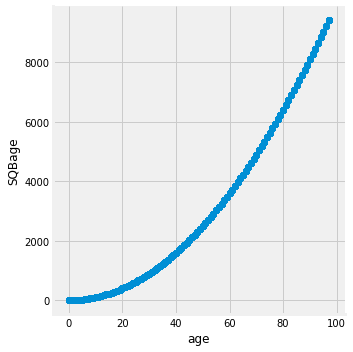

In [5]:
# As should be noted, there's a high correlation btw a values and its square value...
sns.lmplot('age', 'SQBage', data=all_data, fit_reg=False)

In [6]:
# Removing sq variables (they do not add any value since we have the original values)
all_data = all_data.drop(sqr_, axis=1)
all_data.shape

(33413, 136)

### Id Columns
- Id columns should be kept since we need to maintain the same structure

### Household Level Columns

In [7]:
# Subset of the household memebers and their variables
hh_vars = hh_bool + hh_cont + hh_ordered + id_
heads = all_data.loc[all_data['parentesco1'] == 1, hh_vars]
heads.shape

(10307, 99)

Notes:
- We do not need to make much adjustments. However, we could look at values that are too redundant.

In [8]:
def get_corrs_matrix(data, corr_threshold=0.95):
    """ Returns a list: correlation matrix, columns to drop based on the correlation threshold"""
    corr_matrix = data.corr()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    # Find index of feature columns with correlation greater than 0.95
    to_drop = [c for c in upper.columns if any(abs(upper[c]) > corr_threshold)]
    return [corr_matrix, to_drop]


In [9]:
corr_matrix, corr_values = get_corrs_matrix(heads)
corr_values

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

In [10]:
# dataframes that have a high correlation with the correlation values we found above
for drop in corr_values:
    corr_df = corr_matrix.loc[corr_matrix[drop].abs() > 0.9, corr_matrix[drop].abs() > 0.9]
    print(corr_df)


           public   coopele
public   1.000000 -0.967759
coopele -0.967759  1.000000
       area1  area2
area1    1.0   -1.0
area2   -1.0    1.0
                 r4t3    tamhog    tamviv    hhsize  hogar_total
r4t3         1.000000  0.998287  0.910457  0.998287     0.998287
tamhog       0.998287  1.000000  0.909155  1.000000     1.000000
tamviv       0.910457  0.909155  1.000000  0.909155     0.909155
hhsize       0.998287  1.000000  0.909155  1.000000     1.000000
hogar_total  0.998287  1.000000  0.909155  1.000000     1.000000
                 r4t3    tamhog    tamviv    hhsize  hogar_total
r4t3         1.000000  0.998287  0.910457  0.998287     0.998287
tamhog       0.998287  1.000000  0.909155  1.000000     1.000000
tamviv       0.910457  0.909155  1.000000  0.909155     0.909155
hhsize       0.998287  1.000000  0.909155  1.000000     1.000000
hogar_total  0.998287  1.000000  0.909155  1.000000     1.000000
                 r4t3    tamhog    tamviv    hhsize  hogar_total
r4t3       

Notes:
- Perfect correlated values are 
    - hhsize & tmhog
    - hogar_total & hhsize
    - area1 & area2
- Highly correlated values are
    - r4t3 & hhsize
    - r4t3 & hogar_total
    
    
- r4t3, Total persons in the household
- tamhog, size of the household
- tamviv, number of persons living in the household
- hhsize, household size
- hogar_total, # of total individuals in the household

Notice that tamhog, hhsize, and hogar_total are the same variables (could drop two of these)

tamviv does not represent the same as the other values because it indicates how may people are actually in the household. Meaning, we could have more members in the household than the household

In [11]:
# Removing 'tamhog', 'hogar_total', 'r4t3'
heads.drop(['tamhog', 'hogar_total', 'r4t3'], inplace=True, axis=1)

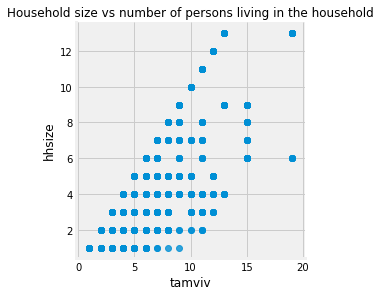

In [12]:
# Visualize hhsize and tamviv
# hhsize is not the same tamviv 
# There could be more people living in a household than the family

sns.lmplot('tamviv', 'hhsize', all_data, fit_reg=False, size=4);
plt.title('Household size vs number of persons living in the household', fontdict={'fontsize': 12});

In [13]:
# Thus, the difference could provide some insight

heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']
heads['hhsize-diff'].value_counts()

0     9901
1       98
2       90
3       84
4       61
5       28
6       14
7       11
8       11
9        8
13       1
Name: hhsize-diff, dtype: int64

In [14]:
# Correlated Values: coopele
elec = []

# Assign values for electricity (ordinal values)
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
# Record the new variable and missing flag
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()

# Remove the electricity columns
heads.drop(['noelec', 'coopele', 'public', 'planpri'], axis=1, inplace=True)

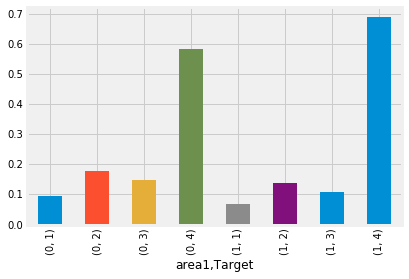

In [15]:
# The final redundant column is area2. 
# This means the house is in a rural zone, but it's redundant because 
# we have a column indicating if the house is in a urban zone. Therefore, we can drop this column.
heads.drop(['area2'], axis=1, inplace=True)

# Observe how area affects the target variables
heads.groupby('area1')['Target'].value_counts(normalize=True).sort_index().plot(kind="bar")

Notes:
- It seems like households in an urban area (value of 1) are more likely to have lower poverty levels than households in a rural area (value of 0).

## Data Enginnering: Feature Creation

### Ordinal Variables

In [16]:
def get_similar_cols(data, groupby_format):
    """Returns columns that follow a similar groupby_format"""
    return data.filter(like=groupby_format, axis=1).columns.tolist()

In [17]:
# Wall Ordinal Variables

walls_columns = get_similar_cols(all_data, groupby_format='epared')
heads['walls'] = np.argmax(np.array(heads[walls_columns]), axis=1)
heads.drop(walls_columns, axis=1, inplace=True)

In [18]:
# Roof Ordinal Variables

roof_columns = get_similar_cols(all_data, groupby_format='etecho')
heads['roof'] = np.argmax(np.array(heads[roof_columns]), axis=1)
heads.drop(roof_columns, axis=1, inplace=True)

In [19]:
# Floor Ordinal Variables

floor_columns = get_similar_cols(all_data, groupby_format='eviv')
heads['floor'] = np.argmax(np.array(heads[floor_columns]), axis=1)
heads.drop(floor_columns, axis=1, inplace=True)

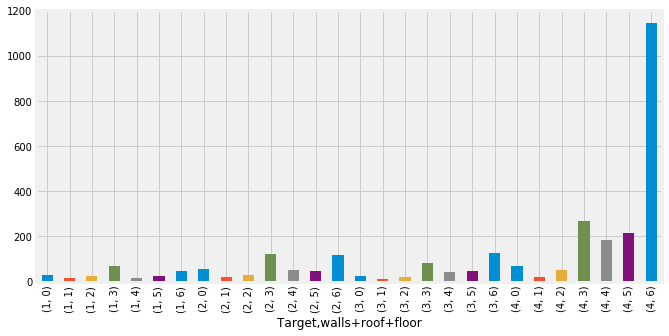

In [20]:
# Create new feature

plt.figure(figsize = (10, 5))
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']
heads.groupby('Target')['walls+roof+floor'].value_counts().sort_index().plot(kind="bar")

Notes:
- This new feature may be useful because it seems like a Target of 4 (the lowes poverty level) tends to have higher values of the 'house quality' variable. 

In [21]:
# Percentage of the each target for each ordinal wall+roof+floor value

counts = pd.DataFrame(heads.groupby(['walls+roof+floor'])['Target'].value_counts(
    normalize=True)).rename(columns = {'Target': 'Normalized Count'}).reset_index()
counts.head(5)

,walls+roof+floor,Target,Normalized Count
0,0,4,0.376404
1,0,2,0.320225
2,0,1,0.162921
3,0,3,0.140449
4,1,4,0.323529


In [22]:
# No toilet, no electricity, no floor, no water service, no ceiling
heads['warning'] = 1 * (heads['sanitario1'] + (heads['elec'] == 0) + 
                        heads['pisonotiene'] + heads['abastaguano'] + 
                        (heads['cielorazo'] == 0))

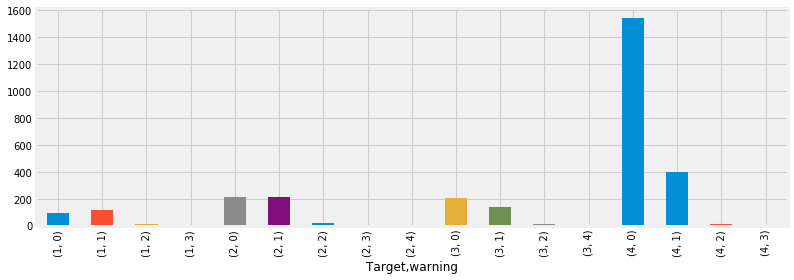

In [23]:
# Plotting the warning variable
plt.figure(figsize = (12, 4))
heads.groupby('Target')['warning'].value_counts().sort_index().plot(kind="bar")

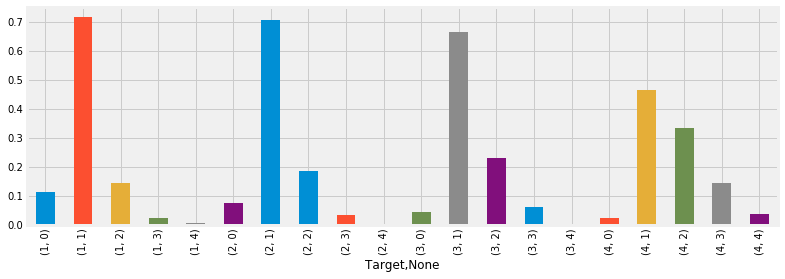

In [24]:
# Owns a refrigerator, computer, tablet, and television
heads['bonus'] = 1 * (heads['refrig'] + 
                      heads['computer'] + 
                      (heads['v18q1'] > 0) + 
                      heads['television'])
# Plotting the bonus variable
plt.figure(figsize=(12,4))
heads.groupby('Target')['bonus'].apply(lambda x: x.value_counts()/len(x)).sort_index().plot(kind="bar")

In [25]:
# Lastly, creating some percentage values
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

## Data Analysis

### Household Variables
There are a numerous method to measure to relationship btw two variables:
- The Pearson Correlation: from -1 to 1 measuring the linear relationship between two variables 
- The Spearman Correlation: from -1 to 1 measuring the monotonic relationship between two variables
- The Spearman correlation is 1 if as one variable increases, the other does as well, even if the relationship is not linear. On the other hand, the Pearson correlation can only be one if the increase is exactly linear. These are best illustrated by example.


Pearson Correlation Guidelines:
- .00-.19 “very weak”
- .20-.39 “weak”
- .40-.59 “moderate”
- .60-.79 “strong”
- .80-1.0 “very strong”

In [26]:
# Only focusing on the training set
heads_train = heads.loc[heads['Target'].notnull(), :].copy()
heads_train['Target'] = heads_train['Target'].astype('int64')
pcorrs = pd.DataFrame(heads_train.corr()['Target'].sort_values(ascending=False)).rename(columns=
                                                                        {"Target": 'P_corr'}).reset_index()

# Top positive correlated Values
pcorrs = pcorrs.rename(columns={'index': 'feature'})
pcorrs.head(6)[1:]

,feature,P_corr
1,meaneduc,0.333652
2,walls+roof+floor,0.332446
3,floor,0.307605
4,phones-per-capita,0.299026
5,walls,0.298737


In [27]:
# Top negative correlated values
pcorrs.dropna().tail(5)

,feature,P_corr
87,r4m1,-0.209479
88,overcrowding,-0.234954
89,r4t1,-0.260917
90,hogar_nin,-0.266309
91,warning,-0.301791


Notes:
- Negative correlation: as we increase the value, poverty will increase. E.g. as our warning increases, the level of poverty will begin to decrease. 
- Overcrowing and hogar_nin (children under the age of 19) worsen poverty for households.
- For the positive values, walls, roof, and floor indicates that an improvement in those variables will eventually decrease poverty.


Spearman Correlation:

In [28]:
import warnings
from scipy.stats import spearmanr

warnings.filterwarnings('ignore', category = RuntimeWarning)

feats = []
scorr = []
pvalues = []

# Iterate through each column
for c in heads:
    # Only valid for numbers
    if heads[c].dtype != 'object':
        feats.append(c)
        
        # Calculate spearman correlation
        scorr.append(spearmanr(heads_train[c], heads_train['Target']).correlation)
        pvalues.append(spearmanr(heads_train[c], heads_train['Target']).pvalue)

# Top Positive correlated values
scorrs = pd.DataFrame({'feature': feats, 'S_corr': scorr, 'pvalue': pvalues}).sort_values('S_corr', ascending=False)
scorrs.head(5)

,feature,S_corr,pvalue
85,walls+roof+floor,0.338791,9.539346e-81
88,phones-per-capita,0.337377,4.760104e-80
84,floor,0.309638,4.466091e-67
22,cielorazo,0.300996,2.611808e-63
82,walls,0.298963,1.925370e-62


In [29]:
# Top negative correlated values
scorrs.dropna().tail(5)

,feature,S_corr,pvalue
7,pisocemento,-0.209387,8.270816e-31
69,r4t1,-0.219226,1.112230e-33
74,hogar_nin,-0.236225,5.567218e-39
57,dependency,-0.281516,2.792620e-55
86,warning,-0.307326,4.682829e-66


In [30]:
# Notice that both correlation matrix have identical values
# lets find their differences

corrs = pcorrs.merge(scorrs, on='feature')
corrs['diff'] = corrs['P_corr'] - corrs['S_corr']
corrs['abs_diff'] = np.abs(corrs['diff'])
corrs.sort_values(by='diff', ascending=False).head(5)

,feature,P_corr,S_corr,pvalue,diff,abs_diff
77,dependency,-0.126465,-0.281516,2.792620e-55,0.155051,0.155051
31,edjefa,0.052310,0.005114,7.804715e-01,0.047197,0.047197
10,edjefe,0.235687,0.214736,2.367521e-32,0.020951,0.020951
46,hogar_mayor,-0.025173,-0.041722,2.290994e-02,0.016549,0.016549
39,techozinc,0.014357,0.003404,8.528369e-01,0.010954,0.010954


In [31]:
# Top difference variables for correlation
corrs.sort_values(by='diff', ascending=True).head(5)

,feature,P_corr,S_corr,pvalue,diff,abs_diff
19,rooms-per-capita,0.152185,0.223303,6.521453e-35,-0.071119,0.071119
88,r4t1,-0.260917,-0.219226,1.112230e-33,-0.041691,0.041691
3,phones-per-capita,0.299026,0.337377,4.760104e-80,-0.038351,0.038351
86,r4m1,-0.209479,-0.171953,3.649343e-21,-0.037526,0.037526
89,hogar_nin,-0.266309,-0.236225,5.567218e-39,-0.030084,0.030084


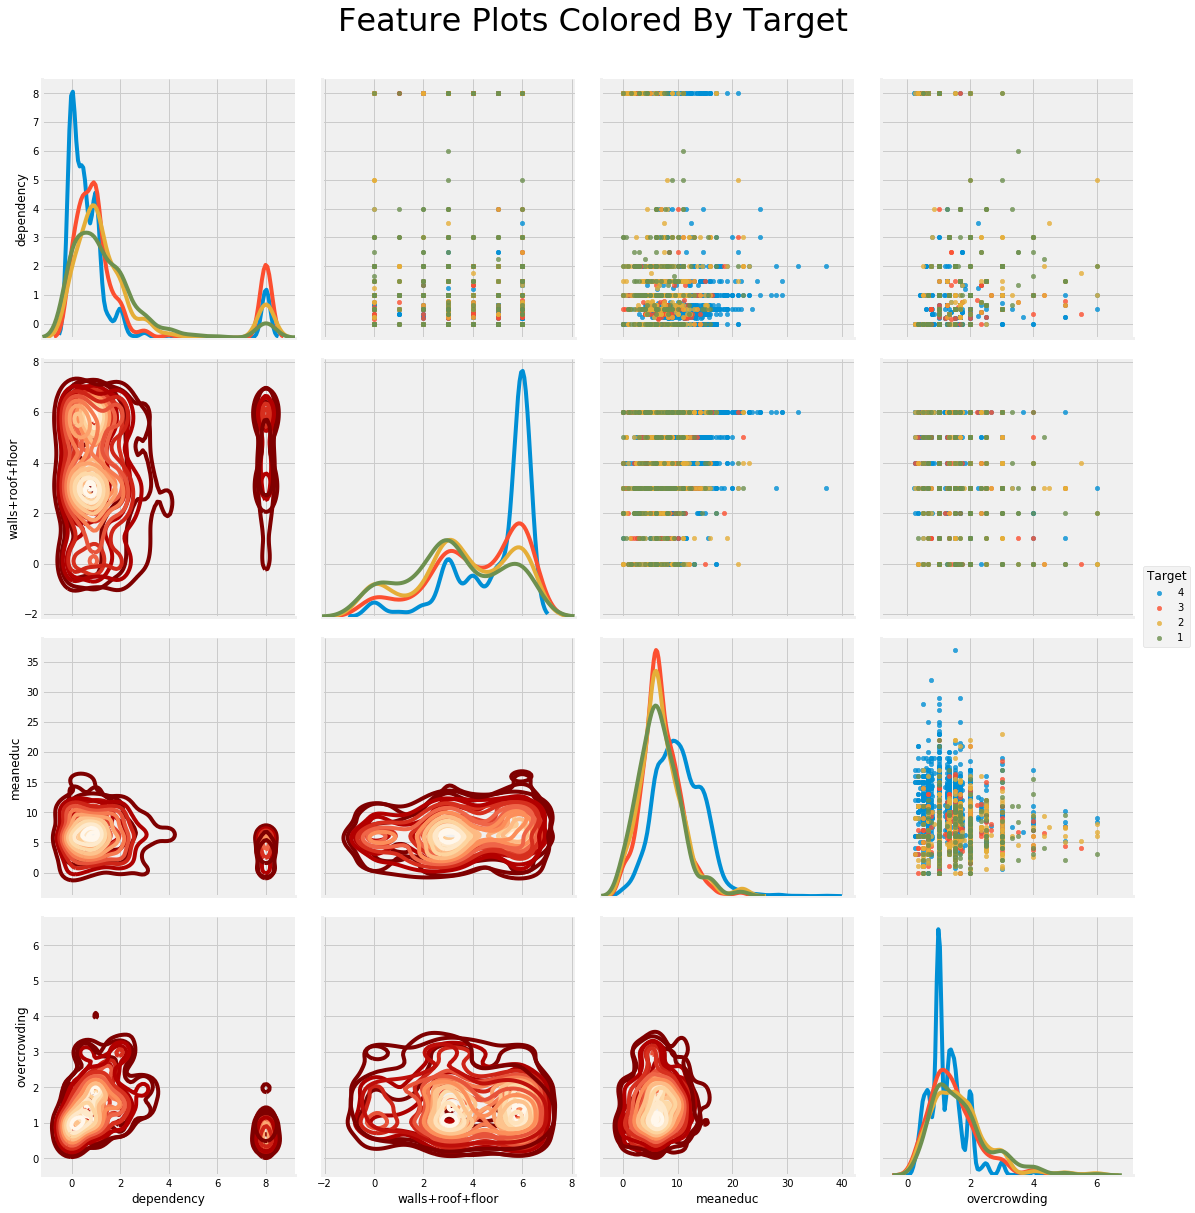

In [32]:
# Plotting plots/charts amongst the most correlated values

import warnings
warnings.filterwarnings('ignore')

# Chosen by the author of the workbook
plot_data = heads_train[['Target', 'dependency', 'walls+roof+floor',
                         'meaneduc', 'overcrowding']]

# Create the pairgrid object
grid = sns.PairGrid(data=plot_data, size=4, diag_sharey=False,
                    hue='Target', hue_order=[4, 3, 2, 1], 
                    vars=[x for x in list(plot_data.columns) if x != 'Target'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.8, s = 20)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);
grid = grid.add_legend()
plt.suptitle('Feature Plots Colored By Target', size = 32, y = 1.05);

In [33]:
# Storing the household columns
household_feats = list(heads.columns)

### Individial Variables

In [34]:
ind = all_data[id_+ind_bool+ind_ordered]
ind.shape

(33413, 40)

In [35]:
corr_matrix, corrs_to_drop = get_corrs_matrix(ind)
corrs_to_drop

['female']

In [36]:
# We already have the male variable, lets keep the female variables
ind.drop(['male'], axis=1, inplace=True)

In [37]:
instl_vars = get_similar_cols(ind, 'instl')
ind[instl_vars].head(5)

,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0


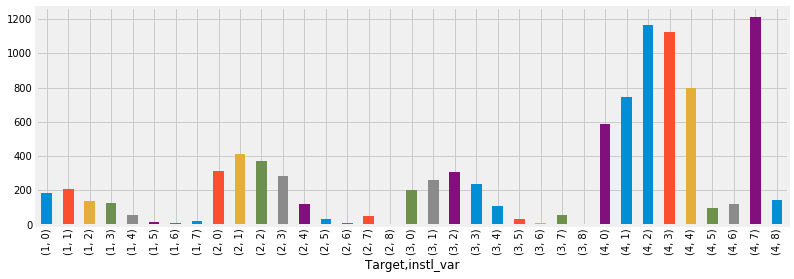

In [38]:
# Creating the ordinal columns with the variables from above

ind['instl_var'] = np.argmax(np.array(ind[[c for c in instl_vars]]), axis=1)
plt.figure(figsize=(12, 4))
ind.groupby('Target')['instl_var'].value_counts().sort_index().plot(kind="bar")
#.plot(kind='bar', )

Notes:
- Higher level of education can reduce poverty

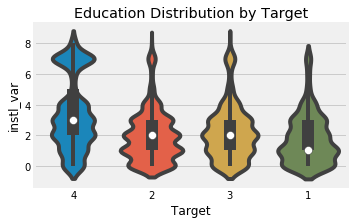

In [39]:
plt.figure(figsize = (5, 3))
sns.violinplot(x='Target', y='instl_var', data=ind);
plt.title('Education Distribution by Target');

In [40]:
ind.shape

(33413, 40)

## Data Engineering

In [41]:
# An important component woul dbe to find the ratio of specific metrics
# Normalizing the value to an appropriate metrics could be useful to find its improtance 

# The total number of schooling by age could reveal if their education has an important weight in their lvies
ind['escolari/age'] = ind['escolari']/ind['age']

# The level of education by their age
ind['instl_var/age'] = ind['instl_var']/ind['age']

# We can also calculate the years behind in school. Could they be old and still in school?
ind['rez_esc/age'] = ind['rez_esc']/ind['age']

In [42]:
# Other than ratio, we could find similar items
# e.g., we could at the tech gadgets in a household
ind['tech_gadgets'] = ind['mobilephone'] + ind['v18q']

### Feature Enginnering: Aggregations

In [43]:
# Creating the range functions
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'


# Group and aggregate
ind_agg = ind.drop(['Target'], axis=1).groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

v18q                           dis                ...   rez_esc/age  \
           min max sum count  std range_ min max sum count  ...           sum   
idhogar                                                     ...                 
000a08204    1   1   3     3  0.0      0   0   0   0     3  ...           0.0   
000bce7c4    0   0   0     2  0.0      0   0   1   1     2  ...           0.0   
001845fb0    0   0   0     4  0.0      0   0   0   0     4  ...           0.0   
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  ...           0.0   
003123ec2    0   0   0     4  0.0      0   0   0   0     4  ...           0.0   

                            tech_gadgets                            
          count  std range_          min max sum count  std range_  
idhogar                                                             
000a08204     3  0.0    0.0            2   2   6     3  0.0      0  
000bce7c4     2  0.0    0.0            1   1   2     2  0.0      0  
001845fb0     3  0.0    0.0            1   1   4     4  0.0      0  
001ff74ca     1  NaN    0.0            2   2   4     2  0.0      0  
003123ec2     4  0.0    0.0            1   1   4     4  0.0      0  

[5 rows x 240 columns]

In [44]:
# Renaming the aggreagation columns
new_col = []
for col in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        new_col.append(f'{col}-{stat}')
        
ind_agg.columns = new_col
ind_agg.head(5)

,v18q-min,v18q-max,v18q-sum,v18q-count,v18q-std,v18q-range_,dis-min,dis-max,dis-sum,dis-count,...,rez_esc/age-sum,rez_esc/age-count,rez_esc/age-std,rez_esc/age-range_,tech_gadgets-min,tech_gadgets-max,tech_gadgets-sum,tech_gadgets-count,tech_gadgets-std,tech_gadgets-range_
idhogar,,,,,,,,,,,,,,,,,,,,,
000a08204,1,1,3,3,0.0,0,0,0,0,3,...,0.0,3,0.0,0.0,2,2,6,3,0.0,0
000bce7c4,0,0,0,2,0.0,0,0,1,1,2,...,0.0,2,0.0,0.0,1,1,2,2,0.0,0
001845fb0,0,0,0,4,0.0,0,0,0,0,4,...,0.0,3,0.0,0.0,1,1,4,4,0.0,0
001ff74ca,1,1,2,2,0.0,0,0,0,0,2,...,0.0,1,NaN,0.0,2,2,4,2,0.0,0
003123ec2,0,0,0,4,0.0,0,0,0,0,4,...,0.0,4,0.0,0.0,1,1,4,4,0.0,0


In [45]:
# Removing the variables that are redundant
corr_matrix, ind_agg_to_drop = get_corrs_matrix(ind_agg)
len(ind_agg_to_drop)

117

In [46]:
# Storing the individual variables
ind_agg = ind_agg.drop(ind_agg_to_drop, axis=1)
ind_feats = ind_agg.columns.tolist()

In [47]:
# Merging with household data
final_ = heads.merge(ind_agg, on='idhogar', how='left')

print("Shape of the final dataset is {}".format(final_.shape))

Shape of the final dataset is (10307, 218)


In [48]:
final_.head(5)

,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,...,escolari/age-sum,escolari/age-std,escolari/age-range_,instl_var/age-max,instl_var/age-std,instl_var/age-range_,tech_gadgets-min,tech_gadgets-sum,tech_gadgets-std,tech_gadgets-range_
0,0,0,1,1,1,0,0,0,0,0,...,0.232558,NaN,0.000000,0.069767,NaN,0.000000,1,1,NaN,0
1,0,0,1,1,0,0,0,0,0,1,...,0.179104,NaN,0.000000,0.104478,NaN,0.000000,2,2,NaN,0
2,0,0,1,1,0,0,0,0,0,1,...,0.119565,NaN,0.000000,0.043478,NaN,0.000000,0,0,NaN,0
3,0,0,1,1,1,0,0,0,0,0,...,1.366183,0.126943,0.279412,0.176471,0.033010,0.071207,2,8,0.0,0
4,1,0,1,1,1,0,0,0,0,0,...,0.965584,0.168946,0.392857,0.142857,0.060063,0.142857,1,4,0.0,0


## Data Analysis
- Will continue to do further research

In [49]:
final_['Target'] = final_['Target'].dropna().astype('int64')
corrs = final_.corr()['Target']

# Most positives values related to target
corrs.sort_values().head()

warning          -0.301791
instlevel2-sum   -0.297868
instlevel1-sum   -0.271204
hogar_nin        -0.266309
r4t1             -0.260917
Name: Target, dtype: float64

In [50]:
# Most negative correlated values
corrs.sort_values().dropna().tail(6)[:5]

instlevel8-max      0.317815
walls+roof+floor    0.332446
meaneduc            0.333652
instl_var-max       0.368229
escolari-max        0.373091
Name: Target, dtype: float64

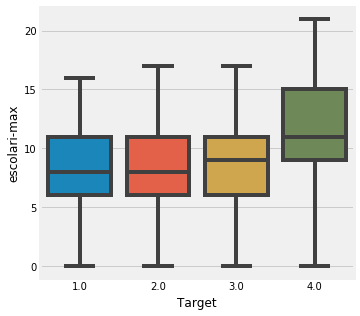

In [51]:
# Plotting boxplots for highly correlates values
plt.figure(figsize=(5,5))
sns.boxplot(x='Target', y='escolari-max', data=final_)

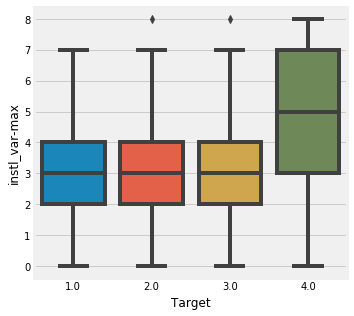

In [52]:
# Plotting boxplots for highly correlates values
plt.figure(figsize=(5,5))
sns.boxplot(x='Target', y='instl_var-max', data=final_)

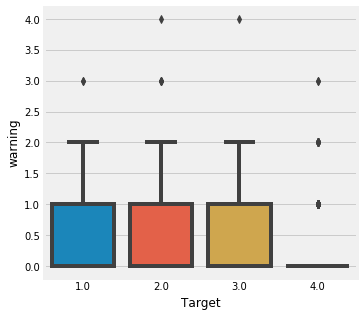

In [53]:
# Plotting boxplots for highly correlates values
plt.figure(figsize=(5,5))
sns.boxplot(x='Target', y='warning', data=final_)

In [54]:
# Finding female head gender
head_gender = ind.loc[ind['parentesco1'] == 1, ['idhogar', 'female']]
final_ = final_.merge(head_gender, on='idhogar', how='left').rename(columns={'female': 'female-head'})

In [55]:
# Understanding the
final_.groupby('female-head')['Target'].value_counts(normalize=True)

female-head  Target
0            4.0       0.682873
             2.0       0.136464
             3.0       0.123204
             1.0       0.057459
1            4.0       0.617369
             2.0       0.167670
             3.0       0.113500
             1.0       0.101462
Name: Target, dtype: float64

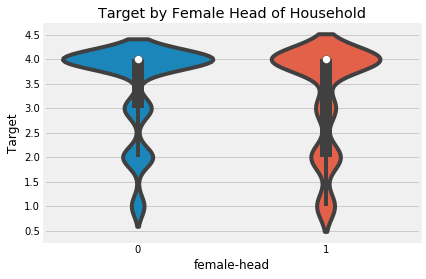

In [56]:
sns.violinplot(x='female-head', y='Target', data=final_);
plt.title('Target by Female Head of Household');

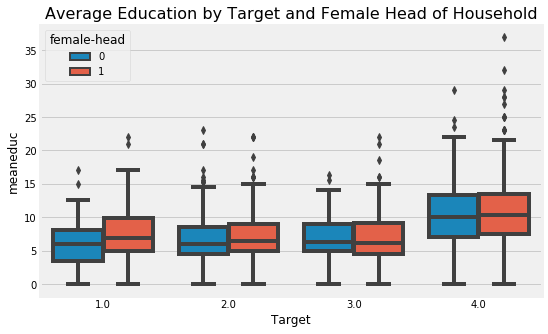

In [57]:
plt.figure(figsize = (8, 5))
sns.boxplot(x='Target', y='meaneduc', hue='female-head', data=final_);
plt.title('Average Education by Target and Female Head of Household', size = 16);

In [58]:
final_.groupby('female-head')['meaneduc'].agg(['mean', 'count'])

,mean,count
female-head,,
0,8.968025,6384
1,9.237013,3903


Notes:
- Despite females having higher levels of education, we can see that they will have higher less of poverty if they are the head of the household.

## Saving Datasets

In [60]:
final_.to_pickle('./pickles/final.pkl')